<a href="https://colab.research.google.com/github/Sakshamgoel/homocomp/blob/main/homocomp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install scikit-bio
!pip install plotnine
!pip install scipy

# Run this if importing from plotnine fails
#!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import numpy as np
import pyabpoa as pa
from skbio.alignment import global_pairwise_align_nucleotide
from skbio import TabularMSA, DNA
import statistics

import pandas as pd

from plotnine import *
from plotnine.data import *

In [18]:
def generate_sequence(n):
    return("".join(np.random.choice(["A","C","G","T"], n)))

def mutate(str, snp_rate, indel_rate):
    x = [c for c in str]
    i = 0
    while i < len(x):
        if np.random.random() < snp_rate:
            x[i] = generate_sequence(1)
        if np.random.random() < indel_rate:
            length = np.random.geometric(0.5)
            if np.random.random() < 0.5: # insertion
                x[i] = x[i] + generate_sequence(length)
            else:
                for j in range(i,i+length):
                    if j < len(x):
                        x[j] = ""
                        i += 1
        i += 1
    return("".join(x))

In [4]:
"""
homoCompress
This function preforms homopolymer compression on a given
sequence.
@param seq: The sequence to preform homopolyer compression on
@return a tuple with the first element being an array with the 
    string values of the homopolymer compression and the second
    array in the tuple is an array with the count of each base at
    that location in the array.
"""
def homoCompress(seq):
    compSeq = []
    countSeq = []
    i = 0
    while i < len(seq):
        starter = seq[i]
        count = 1
        p = i + 1
        while p < len(seq) and seq[i] == seq[p]:
            p = p + 1
            i = i + 1
            count = count + 1
        compSeq.append(starter)
        countSeq.append(count)
        i = i + 1
    return ("".join(compSeq), countSeq)

In [5]:
def compressedPartialOrderAllignment(seqs):
    seqsReadyForPoa = []
    seqCounts = []
    for seq in seqs:
        homoCompTuple = homoCompress(seq)
        seqReady = homoCompTuple[0]
        seqSingleCount = homoCompTuple[1]
        seqsReadyForPoa.append(seqReady)
        seqCounts.append(seqSingleCount)
        
    #print(seqsReadyForPoa)
    #print(seqCounts)
    a = pa.msa_aligner()
    res=a.msa(seqsReadyForPoa, out_cons=True, out_msa=True, out_pog='pog.png', incr_fn='') # perform multiple sequence alignment 
                                                                # generate a figure of alignment graph to pog.png
    return(res.cons_seq[0])
    #for seq in res.cons_seq:
       # print(seq)

In [6]:
def partialOrderAllignment(seqs):

    a = pa.msa_aligner()
    res=a.msa(seqs, out_cons=True, out_msa=True, out_pog='pog.png', incr_fn='') # perform multiple sequence alignment 
                                                                # generate a figure of alignment graph to pog.png
    return(res.cons_seq[0])
    #for seq in res.cons_seq:
       # print(seq)
       
       
def pairwiseAlign(seqs, consenSeq):
    for seq in seqs:
        alignment = global_pairwise_align_nucleotide(DNA(consenSeq), DNA(seqs[seq][0]))
        seqs[seq] = seqs[seq] + ([str(alignment[0][0]), str(alignment[0][1])],)
        print(alignment[0][0])
        print(alignment[0][1])
        print("\n")
    return seqs

In [7]:
def expansionMean(toExpandWith, consenSeq):

    locDict = {}
    for align in toExpandWith:
        locArray = []
        topSeq = toExpandWith[align][2][0]
        botSeq = toExpandWith[align][2][1]
        consensusLoc = 0
        allignLoc = 0
        while consensusLoc < len(topSeq):
            if topSeq[consensusLoc] != "-": 
                if (topSeq[consensusLoc] == botSeq[consensusLoc]): #match
                    locArray.append(allignLoc)
                    allignLoc+=1
                elif botSeq[consensusLoc] == "-": #deletion
                    locArray.append(-1)
                else: #mismatch
                    locArray.append(-1)
                    allignLoc+=1
            else:
                allignLoc+=1
                
            
            consensusLoc += 1  
        locDict[align] = locArray
    finalStr = ""
    finalArr = []
    for base in range(len(consenSeq)):
        if (base == 14):
            numToDivide = 0
            count = 0
            for key in locDict:
                if locDict[key][base] != -1:
                    #print("locDict[key][base]")
                    #print(locDict[key][base])
                    #print("toExpandWith[key][1][locDict[key][base]]")
                 
                    #print(toExpandWith[key][1][locDict[key][base]])
                    numToDivide = numToDivide + toExpandWith[key][1][locDict[key][base]]
                    count += 1
        else:
            numToDivide = 0
            count = 0
            for key in locDict:
                if locDict[key][base] != -1:
                    numToDivide = numToDivide + toExpandWith[key][1][locDict[key][base]]
                    count += 1
        finalBaseLength = 0
        if (count > 0): 
            finalBaseLength = round(numToDivide/count)
            
        charCount = 0
        while charCount < finalBaseLength:
            finalStr = finalStr + consenSeq[base]
            charCount+=1
        
                
    return finalStr

In [8]:
def expansionMedian(toExpandWith, consenSeq):

    locDict = {}
    for align in toExpandWith:
        locArray = []
        topSeq = toExpandWith[align][2][0]
        botSeq = toExpandWith[align][2][1]
        consensusLoc = 0
        allignLoc = 0
        while consensusLoc < len(topSeq):
            if topSeq[consensusLoc] != "-": 
                if (topSeq[consensusLoc] == botSeq[consensusLoc]): #match
                    locArray.append(allignLoc)
                    allignLoc+=1
                elif botSeq[consensusLoc] == "-": #deletion
                    locArray.append(-1)
                else: #mismatch
                    locArray.append(-1)
                    allignLoc+=1
            else:
                allignLoc+=1
                
            
            consensusLoc += 1  
        locDict[align] = locArray
    finalStr = ""
    finalArr = []
    for base in range(len(consenSeq)):
        medianArr = []
        for key in locDict:
            if locDict[key][base] != -1:
                medianArr.append(toExpandWith[key][1][locDict[key][base]])
        finalBaseLength = 0
        if (len(medianArr) > 0):
            finalBaseLength = statistics.median(medianArr)
        charCount = 0
        while charCount < finalBaseLength:
            finalStr = finalStr + consenSeq[base]
            charCount+=1
        
                
    return finalStr

In [9]:
def expansionMode(toExpandWith, consenSeq):

    locDict = {}
    for align in toExpandWith:
        locArray = []
        topSeq = toExpandWith[align][2][0]
        botSeq = toExpandWith[align][2][1]
        consensusLoc = 0
        allignLoc = 0
        while consensusLoc < len(topSeq):
            if topSeq[consensusLoc] != "-": 
                if (topSeq[consensusLoc] == botSeq[consensusLoc]): #match
                    locArray.append(allignLoc)
                    allignLoc+=1
                elif botSeq[consensusLoc] == "-": #deletion
                    locArray.append(-1)
                else: #mismatch
                    locArray.append(-1)
                    allignLoc+=1
            else:
                allignLoc+=1
                
            
            consensusLoc += 1  
        locDict[align] = locArray
    finalStr = ""

    for base in range(len(consenSeq)):
        modeArr = []
        for key in locDict:
            if locDict[key][base] != -1:
                modeArr.append(toExpandWith[key][1][locDict[key][base]])
        finalBaseLength = 0
        if (len(modeArr) > 0):
            finalBaseLength = statistics.median(modeArr)
        charCount = 0
        while charCount < finalBaseLength:
            finalStr = finalStr + consenSeq[base]
            charCount+=1
        
                
    return finalStr

In [10]:
def calcAvgScore(seqs, allignmentToTest):
    avgToDivide = 0
    for seq in seqs:
        alignment = global_pairwise_align_nucleotide(DNA(allignmentToTest), DNA(seq))
        avgToDivide += alignment[1]
    finalAverage = avgToDivide/len(seqs)
    return finalAverage


In [11]:
# seqs=[]
# smallbase = generate_sequence(20)
# s1 = mutate(smallbase, 0.1, 0.1)
# s2 = mutate(smallbase, 0.1, 0.1)
# s3 = mutate(smallbase, 0.1, 0.1)

# s1 = mutate(baseSeq, 0.1, 0.1)
# s2 = mutate(baseSeq, 0.1, 0.1)
# s3 = mutate(baseSeq, 0.1, 0.1)
# s4 = mutate(baseSeq, 0.1, 0.1)
# s5 = mutate(baseSeq, 0.1, 0.1)
# s6 = mutate(baseSeq, 0.1, 0.1)

# s11 = mutate(baseSeq, 0.1, 0.1)
# s22 = mutate(baseSeq, 0.1, 0.1)
# s33 = mutate(baseSeq, 0.1, 0.1)
# s44 = mutate(baseSeq, 0.1, 0.1)
# s55 = mutate(baseSeq, 0.1, 0.1)
# s66 = mutate(baseSeq, 0.1, 0.1)

# seqs.append(s1)
# seqs.append(s2)
# seqs.append(s3)
# seqs.append(s4)
# seqs.append(s5)
# seqs.append(s6)

# seqs.append(s11)
# seqs.append(s22)
# seqs.append(s33)
# seqs.append(s44)
# seqs.append(s55)
# seqs.append(s66)

# poaCompressed = compressedPartialOrderAllignment(seqs)

# print("### Sequences Before Compression ###")
# for seq in seqs:
#     print(seq)
# print("\n\n")

# print("### Sequences After Compression ###")
# homecompSeqs = {}
# homoId = 0
# for seq in seqs:
#     print(homoCompress(seq)[0])
#     print(homoCompress(seq)[1])
#     homecompSeqs[homoId] = homoCompress(seq)
#     homoId = homoId + 1
# print("\n\n")


# print("### Consensus Sequence Before Expansion ###")
# print(poaCompressed)
# print("\n\n")
# print(seqs)
# print("\n\n")
# print("### GLOBAL PAIRWISE ALIGN ###")
# readyForExpansion = pairwiseAlign(homecompSeqs, poaCompressed)


# print("\n\n")
# print("### MEAN EXPANSION FINAL STRING ###")
# finalMean = expansionMean(readyForExpansion, poaCompressed)
# print(finalMean)
# print("\n\n")

# print("### MEDIAN EXPANSION FINAL STRING ###")
# finalMedian = expansionMedian(readyForExpansion, poaCompressed)
# print(finalMedian)
# print("\n\n")

# print("### MODE EXPANSION FINAL STRING ###")
# finalMode = expansionMode(readyForExpansion, poaCompressed)
# print(finalMode)
# print("\n\n")


# print("### Average Alignment Score Compressed Mean ###")
# print(seqs)
# avgMean = calcAvgScore(seqs, finalMean)
# print(avgMean)

# print("### Average Alignment Score Compressed Median ###")
# print(seqs)
# avgMedian = calcAvgScore(seqs, finalMedian)
# print(avgMedian)


# print("### Average Alignment Score Compressed Mode ###")
# print(seqs)
# avgModes = calcAvgScore(seqs, finalMode)
# print(avgModes)



# print("\n\n")
# print("### Partial Order Allignment Without Compression ###")
# poaNonCompressed = partialOrderAllignment(seqs)
# print(poaNonCompressed)
# print(finalMedian)
# print(smallbase)
# print("\n\n")
# print("### Average Alignment Score Without Compression ###")
# print(seqs)
# avgMeanNonComp = calcAvgScore(seqs, poaNonCompressed)
# print(avgMeanNonComp)

In [12]:
data = {"comp": [],
        "seqLength": [],
        "value": []
        }
toCheck = [5, 10, 15, 20, 25]
for checkNum in toCheck:
    meanToAppend = 0
    modeToAppend = 0
    medianToAppend = 0
    nonCompToAppend = 0
    for x in range(10):
        seqs = []
        base = generate_sequence(checkNum)
        s1 = mutate(base, 0.1, 0.1)
        s2 = mutate(base, 0.1, 0.1)
        s3 = mutate(base, 0.1, 0.1)
        
        seqs.append(s1)
        seqs.append(s2)
        seqs.append(s3)
        
        poaCompressed = compressedPartialOrderAllignment(seqs)
        homecompSeqs = {}
        homoId = 0
        for seq in seqs:
            homecompSeqs[homoId] = homoCompress(seq)
            homoId = homoId + 1
            
        readyForExpansion = pairwiseAlign(homecompSeqs, poaCompressed)
        finalMean = expansionMean(readyForExpansion, poaCompressed)
        finalMedian = expansionMedian(readyForExpansion, poaCompressed)
        finalMode = expansionMode(readyForExpansion, poaCompressed)
        
        avgMean = calcAvgScore(seqs, finalMean)
        avgMedian = calcAvgScore(seqs, finalMedian)
        avgMode = calcAvgScore(seqs, finalMode)
        
        poaNonCompressed = partialOrderAllignment(seqs)
        avgMeanNonComp = calcAvgScore(seqs, poaNonCompressed)
        
        meanToAppend += avgMean
        medianToAppend += avgMedian 
        modeToAppend += avgMode
        nonCompToAppend += avgMeanNonComp
    finalMean = meanToAppend/10
    finalMedian = medianToAppend/10
    finalMode = modeToAppend/10
    nonCompToAppend = nonCompToAppend/10
    data["comp"].append("Mean")
    data["comp"].append("Median")
    data["comp"].append("Mode")
    data["comp"].append("NonCompressed")
    data["seqLength"].append(checkNum)
    data["seqLength"].append(checkNum)
    data["seqLength"].append(checkNum)
    data["seqLength"].append(checkNum)
    data["value"].append(finalMean)
    data["value"].append(finalMedian)
    data["value"].append(finalMode)
    data["value"].append(nonCompToAppend)

/usr/local/lib/python3.8/dist-packages/skbio/alignment/_pairwise.py:595: EfficiencyWarning: You're using skbio's python implementation of Needleman-Wunsch alignment. This is known to be very slow (e.g., thousands of times slower than a native C implementation). We'll be adding a faster version soon (see https://github.com/biocore/scikit-bio/issues/254 to track progress on this).


-----TGCGCG
TGACG------


TGCGCG
TGCGCG


TGCGCG
TGCG--


TAGCT
TAGCT


TAGCT
TAGCG


--------TAGCT
TCAGACTCT----


-ACGC
TACGC


ACGC
ACGC


---ACGC
AGT----


CTCT
CT--


CTCT
CTCT


CTCT
CTC-


TCGAT
TCGAT


--TCGAT
TGT----


TCGAT
TCGAT


ATCTC
ATCTC


ATCTC
ATCTC


ATCTC
ATCTC


CGACA
CGACA


CGACA
CGACA


CGACA
CGACA


ATGCA
ATGCA


ATGCA
--GCA


ATGCA-
ATGCAT


TAGCG
TAGCG


TAGCG
TAGCT


TAGCG
TAG--


-----TATCAC
TAGAC------


---TATCAC
TAC------


TATCAC
TATCAC


------GAGACTAC
GCTGAC--------


GAGACTAC
GTGACTAC


--------GAGACTAC
GAGATATC--------


CATCAGACTC
CATCAGAC--


CATCAGACTC
---CATACTC


CATCAGACTC
CATCAGACTC


GCACTGTCAGTAG
GCACTGT-AGTAG


GCACTGTCAGTAG
---GTGTCAGTG-


GCACTGTCAGTAG
-----GTCAG-AG


GCTACAGATGAT
GCT-CAGAT---


GCTACAGATGAT
GCTACAT-----


GCTACAGATGAT
GCTACAGATGAT


AGTCGATAGT
AGT-------


AGTCGATAGT
AGTCGATAGT


AGTCGATAGT
AGTCGAT-GT


---GTGCTAC
CTAG------


GTGCTAC
GTGCTAC


GTGCTAC
GTGCTAC


ATCGCGCAGC
ATCT-GCAGC


ATCGCGCAGC
---ACGCAGC


ATCGCGCAGC

In [13]:
df = pd.DataFrame(data)

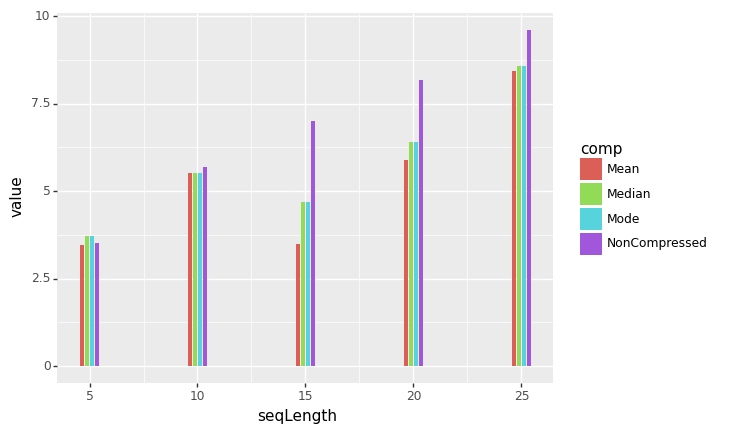

In [14]:
print(ggplot(df) + geom_bar(aes(x="seqLength", y="value", fill="comp"), stat = "identity", position = "dodge2"))